In [1]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nabinagahatraj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load the dataset
data= pd.read_csv("/Users/nabinagahatraj/Desktop/BDA66/Amazon.txt", delimiter= '\t')


In [4]:
#Explore the dataset (EDA)
print(data.head())

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  


In [5]:
print(f"Dataset Shape:", {data.shape})

Dataset Shape: {(3150, 5)}


In [6]:
print(f"Features Names: {data.columns.values}")

Features Names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [7]:
#Check for NUll values
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

#### One Null value found in the "verified_reviews" column. let's drop the null value from that column.

In [9]:
#Dropping the null value from the dataset
data.dropna(inplace=True)

In [10]:
print(f"Dataset Shape after removing the Null Values: {data.shape}")


Dataset Shape after removing the Null Values: (3149, 5)


In [11]:
#Checking the data types
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

#### - rating and feedback  are integer values.
#### - date, variation and verified_reviews are string values.

In [13]:
#Analyzing the Rating Column
len(data)

3149

In [14]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


#### Let's plot the above values in a bar graph

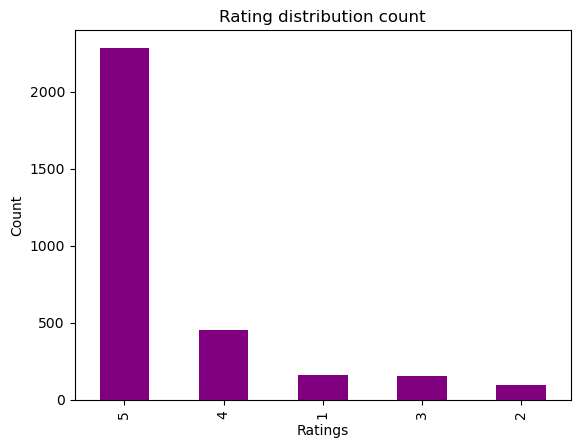

In [16]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'Purple')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

#### Analyzing the 'feedback' column

In [18]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


#### There are 2 distinct values of 'feedback' present i.e. 0 and 1. Let's see what kind of review each value corresponds to.

In [20]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [21]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


#### From the above 2 examples we can see that feedback 0 is "negative review" and 1 is "positive review".

#### Let's plot the feedback value count in a bar graph

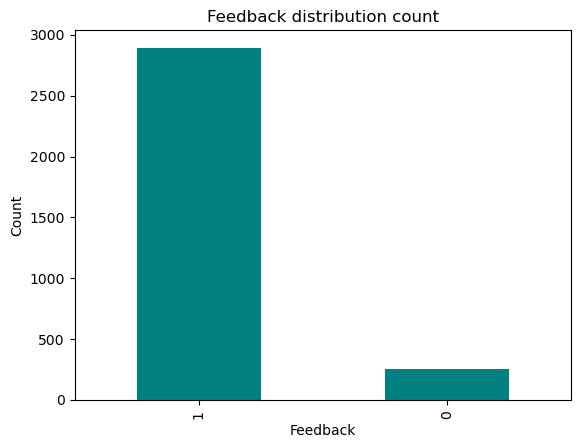

In [23]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'Teal')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

#### Let's see the 'rating' values for different values of 'feedback'

In [25]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [26]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

#### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Preprocessing and Modelling
#### To build the corpus from the 'verified_reviews' we perform the following:
#### 1. Tokenization
#### 2. Converting to lower case
#### 3. Removing Stopwords
#### 4. Replace any non alphabet characters with a space
#### 5. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus.


In [29]:
STOPWORDS = set(stopwords.words('english'))
nltk.download('punkt')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nabinagahatraj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
import torch

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [32]:
# Convert star ratings to binary sentiment
def label_sentiment(rating):
    return 'Positive' if rating >= 3 else 'Negative'

data['sentiment'] = data['rating'].astype(int).apply(label_sentiment)


In [33]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)              #text tokenization
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [34]:
data['cleaned_text'] = data['verified_reviews'].apply(preprocess_text)    #storing the preprocessed text in a new column 'cleaned_text'


In [35]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['sentiment'], test_size=0.2, random_state=42, stratify=data['sentiment'])


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer   #To convert the text into numerical features for feeding to ML models

In [37]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [38]:
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [39]:
# Making Predictions on test data
y_pred = model.predict(X_test_tfidf)



### Model Evaluation

In [41]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='Positive')
recall = recall_score(y_test, y_pred, pos_label='Positive')
f1 = f1_score(y_test, y_pred, pos_label='Positive')

#Printing the values
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Accuracy: 0.92
Precision: 0.92
Recall: 1.00
F1 Score: 0.96


#### The Logistic Regression Model has Accuracy 0.92, Precision 0.92, Recall 1.00 and F1 Score 0.96.

### Confusion Matrix

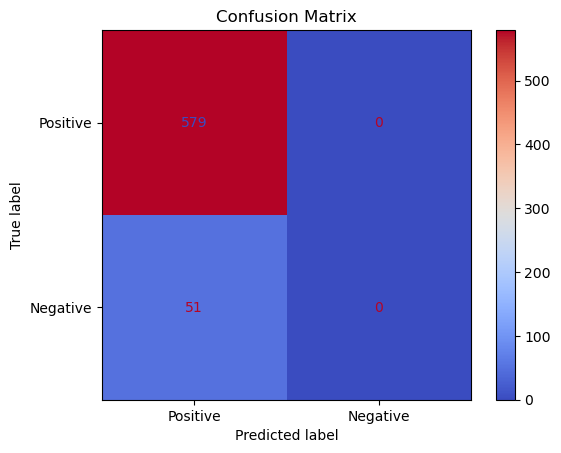

In [44]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Negative'])
disp.plot(cmap='coolwarm')
plt.title('Confusion Matrix')
plt.show()

### Sentiment Distribution Plot

/var/folders/dl/4lcldw7n1gnbk9r573r1pvvm0000gn/T/ipykernel_65226/773136191.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['sentiment'], palette='coolwarm')


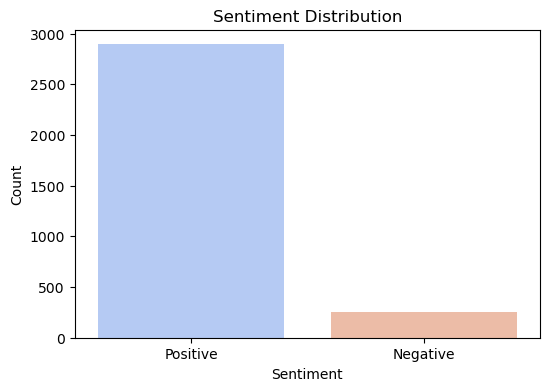

In [46]:
# Visualize sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=data['sentiment'], palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### BERT(Bidirectional Encoder Representations from Transformers)
#### It's designed to understand the context of words in a sentence by considering both the left and right sides of a word(bidirectional),
#### making it highly effective for a variety of Natural Language Processing(NLP) tasks such as question answering, text classification, and language inference.

In [48]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [49]:
# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["cleaned_text"].tolist(), data["sentiment"].tolist(), test_size=0.1, random_state=42)

In [50]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [51]:
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512)


In [52]:
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)


In [121]:
# Convert to Hugging Face Dataset
train_dataset = data.from_dict({"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"], "labels": train_labels})
val_dataset = data.from_dict({"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"], "labels": val_labels})

ValueError: All arrays must be of the same length

In [123]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
from transformers import TrainingArguments, Trainer

In [57]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",       #output directory
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,    #batch size for training
    per_device_eval_batch_size=8,     #batch size for evaluation
    num_train_epochs=3,           #number of training epochs
    weight_decay=0.01,        #strength of weight decay
    logging_dir="./logs",     #directory for storing logs
    logging_steps=10,
    save_strategy="epoch",
)


/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [86]:
# Initialize Trainer
trainer = Trainer(         #the model to be trained
    model=model,
    args=training_args,             #training arguments
    train_dataset=train_dataset,     #training dataset
    eval_dataset=val_dataset,        #evaluation dataset
    tokenizer=tokenizer,
)



/var/folders/dl/4lcldw7n1gnbk9r573r1pvvm0000gn/T/ipykernel_65226/1667418131.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(         #the model to be trained


In [88]:
# Train model
trainer.train()

KeyError: 2462

In [ ]:
# Save model
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

KeyError: 2462